# Survival Analysis Tutorial Part 2: Sessionization

[World of Warcraft avatar dataset](https://www.kaggle.com/datasets/mylesoneill/warcraft-avatar-history), hosted on Kaggle.

It's a dataset that contains logs from a World of Warcraft server from 2008. Every ten minutes the system would log every player from the Horde faction if they were playing the game.

Furthermore, a user that has previously churned and later resubscribed, is treated as a new customer with some covariate information describing the previous subscription history.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")

event_log = pd.read_parquet("data/wowah_data_raw_650k.parquet")
event_log

,char,level,race,charclass,zone,guild,timestamp
0,2288,60,Orc,Hunter,Hellfire Peninsula,-1,2008-01-01 00:02:09
1,49944,70,Orc,Warrior,Terokkar Forest,167,2008-01-01 00:02:19
2,4002,70,Orc,Hunter,The Mechanar,5,2008-01-01 00:02:24
3,64297,48,Tauren,Warrior,Tanaris,-1,2008-01-01 00:02:44
4,65181,26,Tauren,Shaman,Ashenvale,35,2008-01-01 00:02:44
...,...,...,...,...,...,...,...
627398,65852,80,Blood Elf,Hunter,Naxxramas,101,2008-12-31 23:49:48
627399,55037,80,Blood Elf,Priest,Dalaran,204,2008-12-31 23:49:58
627400,34396,80,Blood Elf,Priest,Dalaran,104,2008-12-31 23:49:58
627401,65296,77,Blood Elf,Priest,Dragonblight,62,2008-12-31 23:49:58


In [2]:
event_log["timestamp"].min(), event_log["timestamp"].max()

(Timestamp('2008-01-01 00:02:09'), Timestamp('2008-12-31 23:50:08'))

In [3]:
event_log["char"].value_counts().head()

char
182      42801
65296    10614
65469     9274
29395     9154
31647     8018
Name: count, dtype: int64

In [4]:
def sessionize(df, entity_col, date_col, session_threshold):
    """Create session indices.
    """
    df = df.sort_values([entity_col, date_col])
    df["lag"] = df.groupby(entity_col)[date_col].shift()
    df["is_new_session"] = (df[date_col] - df["lag"]) > session_threshold
    df["session_id"] = df.groupby(entity_col)["is_new_session"].cumsum()
    return df

In [5]:
session_threshold = "90 days"

sessions = sessionize(
    event_log,
    entity_col="char",
    date_col="timestamp",
    session_threshold=session_threshold,
)
print(sessions.shape)
sessions.head()

(627403, 10)


,char,level,race,charclass,zone,guild,timestamp,lag,is_new_session,session_id
11,91,70,Tauren,Druid,Tanaris,103,2008-01-01 00:03:15,NaT,False,0
59,91,70,Tauren,Druid,Tanaris,103,2008-01-01 00:13:03,2008-01-01 00:03:15,False,0
105,91,70,Tauren,Druid,Shattrath City,103,2008-01-01 00:23:28,2008-01-01 00:13:03,False,0
156,91,70,Tauren,Druid,Shattrath City,103,2008-01-01 00:33:16,2008-01-01 00:23:28,False,0
4918,91,70,Tauren,Druid,Shattrath City,103,2008-01-01 23:13:13,2008-01-01 00:33:16,False,0


In [6]:
def extract_session(df, entity_col, date_col, metadata_cols):
    """Group event log into sessions.
    """
    mc_agg = {col: (col, "first") for col in metadata_cols}
    date_agg = dict(session_start=(date_col, "min"), session_end=(date_col, "max"))
    sessions = (
        df.groupby([entity_col, "session_id"])
        .agg(**mc_agg, **date_agg)
        .reset_index()
    )
    sessions["duration"] = (sessions["session_end"] - sessions["session_start"]).dt.days
    return sessions

In [7]:
metadata_cols = ["level", "race", "charclass", "zone", "guild"]

session_extracted = extract_session(
    sessions,
    entity_col="char",
    date_col="timestamp",
    metadata_cols=metadata_cols,
)
print(session_extracted.shape)
session_extracted.head()

(515, 10)


,char,session_id,level,race,charclass,zone,guild,session_start,session_end,duration
0,91,0,70,Tauren,Druid,Tanaris,103,2008-01-01 00:03:15,2008-12-27 22:48:08,361
1,118,0,70,Tauren,Druid,Nagrand,5,2008-01-01 21:13:23,2008-04-08 21:31:22,98
2,132,0,70,Tauren,Warrior,Terokkar Forest,204,2008-01-02 23:53:06,2008-12-31 00:05:51,363
3,155,0,70,Tauren,Warrior,Blade's Edge Mountains,103,2008-01-01 00:53:19,2008-11-14 22:16:59,318
4,166,0,70,Tauren,Shaman,Zangarmarsh,5,2008-01-01 20:43:06,2008-09-30 13:05:45,272


In [8]:
def censor(df, entity_col, censoring_date, session_threshold, observation_days=None):
    """Define censoring with a right-censoring date and a between-session threshold.
    """
    
    df = df.loc[df["session_start"] < censoring_date]
    
    if observation_days:
        start_date = censoring_date - pd.Timedelta(days=observation_days)
        df = df.loc[df["session_start_date"] > start_date]
    
    # Last session churn
    last_session_id = (
        df.groupby(entity_col)
                .agg(last_session_id=("session_id", "last"))
                .reset_index()
    )
    df = df.merge(last_session_id, on=entity_col, how="left")
    
    is_survival = (
        (df["last_session_id"] == df["session_id"])
        & ((censoring_date - df["session_end"]) < session_threshold)
    )

    # Assemble both churn type
    df["event"] = ~is_survival
    
    return df

In [9]:
last_date_observed = session_extracted["session_start"].max()
observation_days = None

censoring = censor(
    session_extracted,
    entity_col="char",
    censoring_date=last_date_observed,
    session_threshold=session_threshold,
    observation_days=observation_days,
)
print(censoring.shape)
censoring.head()

(514, 12)


,char,session_id,level,race,charclass,zone,guild,session_start,session_end,duration,last_session_id,event
0,91,0,70,Tauren,Druid,Tanaris,103,2008-01-01 00:03:15,2008-12-27 22:48:08,361,0,False
1,118,0,70,Tauren,Druid,Nagrand,5,2008-01-01 21:13:23,2008-04-08 21:31:22,98,0,True
2,132,0,70,Tauren,Warrior,Terokkar Forest,204,2008-01-02 23:53:06,2008-12-31 00:05:51,363,0,False
3,155,0,70,Tauren,Warrior,Blade's Edge Mountains,103,2008-01-01 00:53:19,2008-11-14 22:16:59,318,0,False
4,166,0,70,Tauren,Shaman,Zangarmarsh,5,2008-01-01 20:43:06,2008-09-30 13:05:45,272,0,False


In [10]:
def contextualize_churn(df, entity_col):
    """Augment the dataset with context info from previous churned session.
    """
    
    # Get days since last churn
    df["previous_session_end"] = df.groupby(entity_col)["session_end"].shift()
    df["days_since_last_churn"] = (
        df["session_start"] - df["previous_session_end"]
    ).dt.days.fillna(0)
    
    # Get days since first start
    df = df.merge(
        df.groupby("char").agg(first_start=("session_start", "first")),
        on="char",
    )
    df["days_since_first_start"] = (df["session_start"] - df["first_start"]).dt.days
    
    # The number of churn is directly provided by session_id
    df = df.rename({"session_id": "number_of_previous_churn"}, axis=1)
    
    return df

In [11]:
contextualized = contextualize_churn(
    censoring,
    entity_col="char",
)
print(contextualized.shape)
contextualized.head()

(514, 16)


,char,number_of_previous_churn,level,race,charclass,zone,guild,session_start,session_end,duration,last_session_id,event,previous_session_end,days_since_last_churn,first_start,days_since_first_start
0,91,0,70,Tauren,Druid,Tanaris,103,2008-01-01 00:03:15,2008-12-27 22:48:08,361,0,False,NaT,0.0,2008-01-01 00:03:15,0
1,118,0,70,Tauren,Druid,Nagrand,5,2008-01-01 21:13:23,2008-04-08 21:31:22,98,0,True,NaT,0.0,2008-01-01 21:13:23,0
2,132,0,70,Tauren,Warrior,Terokkar Forest,204,2008-01-02 23:53:06,2008-12-31 00:05:51,363,0,False,NaT,0.0,2008-01-02 23:53:06,0
3,155,0,70,Tauren,Warrior,Blade's Edge Mountains,103,2008-01-01 00:53:19,2008-11-14 22:16:59,318,0,False,NaT,0.0,2008-01-01 00:53:19,0
4,166,0,70,Tauren,Shaman,Zangarmarsh,5,2008-01-01 20:43:06,2008-09-30 13:05:45,272,0,False,NaT,0.0,2008-01-01 20:43:06,0


## All together!

In [12]:
def get_X_y(
    event_log,
    date_last_observed,
    session_threshold,
    observation_days=None,
):
    metadata_cols = ["level", "race", "charclass", "zone", "guild"]

    censored = (
        event_log.pipe(
            sessionize,
            entity_col="char",
            date_col="timestamp",
            session_threshold=session_threshold,
        )
        .pipe(
            extract_session,
            entity_col="char",
            date_col="timestamp",
            metadata_cols=metadata_cols,
        )
        .pipe(
            censor,
            entity_col="char",
            censoring_date=last_date_observed,
            session_threshold=session_threshold,
            observation_days=None,
        )
        .pipe(
            contextualize_churn,
            entity_col="char",
        )
    )
        
    churn_cols = [
        "days_since_last_churn",
        "days_since_first_start",
        "number_of_previous_churn",
    ]
    feature_cols = metadata_cols + churn_cols
    X = censored[feature_cols]
    
    target_cols = ["event", "duration"]
    y = censored[target_cols]
        
    return X, y

In [13]:
date_last_observed = event_log["timestamp"].max()
session_threshold = "90 days"

X, y = get_X_y(
    event_log,
    date_last_observed=date_last_observed,
    session_threshold=session_threshold,
    observation_days=None,
)
print(X.shape, y.shape)
X.head()

(514, 8) (514, 2)


,level,race,charclass,zone,guild,days_since_last_churn,days_since_first_start,number_of_previous_churn
0,70,Tauren,Druid,Tanaris,103,0.0,0,0
1,70,Tauren,Druid,Nagrand,5,0.0,0,0
2,70,Tauren,Warrior,Terokkar Forest,204,0.0,0,0
3,70,Tauren,Warrior,Blade's Edge Mountains,103,0.0,0,0
4,70,Tauren,Shaman,Zangarmarsh,5,0.0,0,0


In [14]:
y["event"].value_counts()

event
True     272
False    242
Name: count, dtype: int64

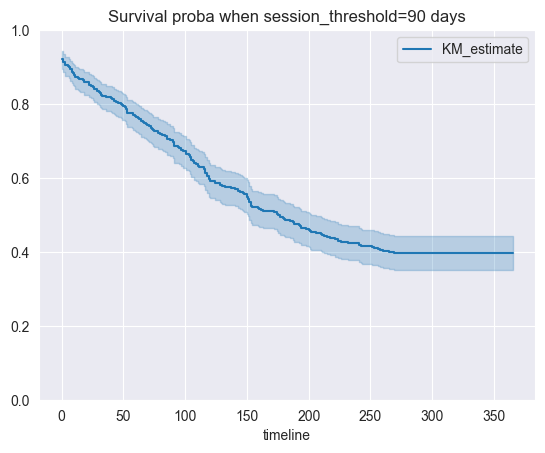

In [15]:
from lifelines import KaplanMeierFitter


km = KaplanMeierFitter()
km.fit(durations=y["duration"], event_observed=y["event"])
km.plot(title=f"Survival proba when session_threshold={session_threshold}")
plt.ylim([0, 1]);

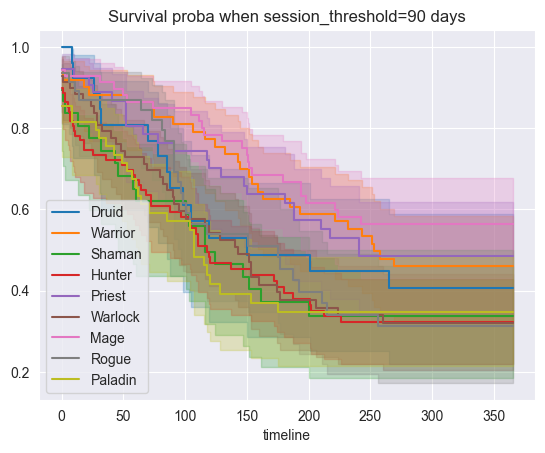

In [16]:
for charclass in X["charclass"].unique():
    y_charclass = y.loc[X["charclass"] == charclass]
    km = KaplanMeierFitter().fit(
        durations=y_charclass["duration"],
        event_observed=y_charclass["event"],
    )
    km.plot(
        title=f"Survival proba when session_threshold={session_threshold}",
        label=charclass,
    );
plt.legend();

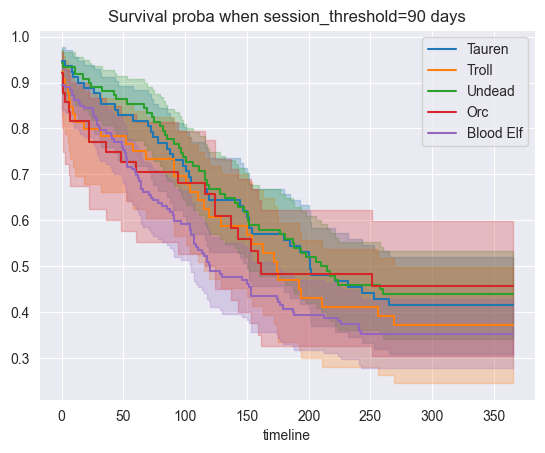

In [17]:
for race in X["race"].unique():
    y_race = y.loc[X["race"] == race]
    km = KaplanMeierFitter().fit(
        durations=y_race["duration"],
        event_observed=y_race["event"],
    )
    km.plot(
        title=f"Survival proba when session_threshold={session_threshold}",
        label=race,
    );
plt.legend();

In [18]:
from sklearn.model_selection import train_test_split


def train_test_split_within(X, y, idx, **kwargs):
    """Ensure that test data durations are within train data durations."""
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, idx, **kwargs)
    mask_duration_inliers = y_test["duration"] < y_train["duration"].max()
    X_test = X_test[mask_duration_inliers]
    y_test = y_test[mask_duration_inliers]
    idx_test = idx_test[mask_duration_inliers]
    return X_train, X_test, y_train, y_test, idx_train, idx_test


X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split_within(
    X, y, np.arange(X.shape[0]), test_size=0.75, random_state=0,
)
X_train.shape, X_test.shape

((128, 8), (359, 8))

In [19]:
def make_test_time_grid(y_train, n_steps=300):
    """Bound times to the range of duration."""
    # Some survival models can fail to predict near the boundary of the
    # range of durations observed on the training set.
    observed_duration = y_test.loc[y_test["event"] > 0]["duration"]
    
    # trim 1% of the span, 0.5% on each end:
    span = observed_duration.max() - observed_duration.min()
    start = observed_duration.min() + 0.005 * span
    stop = observed_duration.max() - 0.005 * span
    return np.linspace(start, stop, num=n_steps)


time_grid = make_test_time_grid(y_train, n_steps=100)
time_grid.shape

(100,)

In [21]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from lifelines import CoxPHFitter

from utils import LifelinesWrapper

categ_cols = ["race", "charclass", "zone"]
to_scale_cols = ["days_since_last_churn", "days_since_first_start", "level"]

ohe = OneHotEncoder(
    max_categories=30,
    sparse_output=False,
    handle_unknown="infrequent_if_exist",
)

simple_transformer = make_column_transformer(
    (ohe, categ_cols),
    remainder="passthrough",
    verbose_feature_names_out=False,
)
cox_ph = LifelinesWrapper(CoxPHFitter(penalizer=1e-4))

cox_ph = make_pipeline(
    simple_transformer,
    cox_ph,
)
cox_ph.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                max_categories=30,
                                                                sparse_output=False),
                                                  ['race', 'charclass',
                                                   'zone'])],
                                   verbose_feature_names_out=False)),
                ('lifelineswrapper',
                 LifelinesWrapper(estimator=<lifelines.CoxPHFitter: fitted with 128 total observations, 53 right-censored observations>))])

In [22]:
simple_cox_survival_probas = cox_ph.predict_survival_function(X_test, times=time_grid)
simple_cox_survival_probas.shape

(359, 100)

,Model,IBS,C-index
0,Simple CoxPH,0.292,0.5457


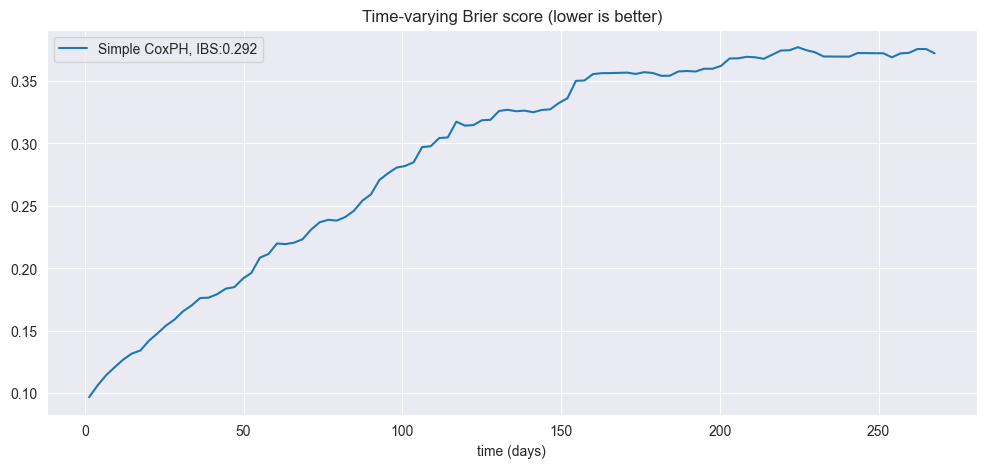

In [23]:
from utils import SurvivalAnalysisEvaluator

evaluator = SurvivalAnalysisEvaluator(y_train, y_test, time_grid)
evaluator("Simple CoxPH", simple_cox_survival_probas)

100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1406.91it/s]


,Model,IBS,C-index
0,Simple CoxPH,0.2920,0.5457
1,Gradient Boosting Incidence,0.2029,0.6371


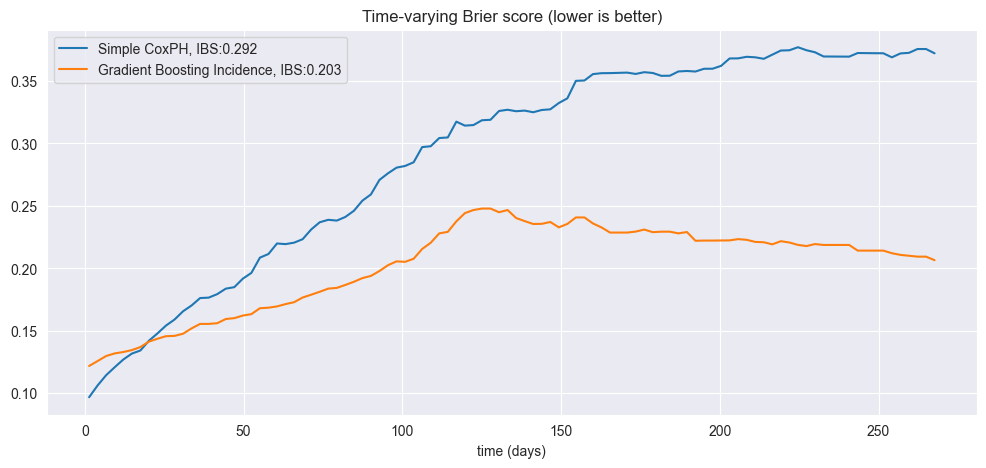

In [24]:
from hazardous.gradient_boosting_incidence import GradientBoostingIncidence

gb_incidence = make_pipeline(
    simple_transformer,
    GradientBoostingIncidence(n_iter=30, max_leaf_nodes=5, learning_rate=0.1),
)
gb_incidence.fit(X_train, y_train)
gb_incidence_survival_probas = gb_incidence.predict_survival_function(X_test, times=time_grid)

evaluator("Gradient Boosting Incidence", gb_incidence_survival_probas)

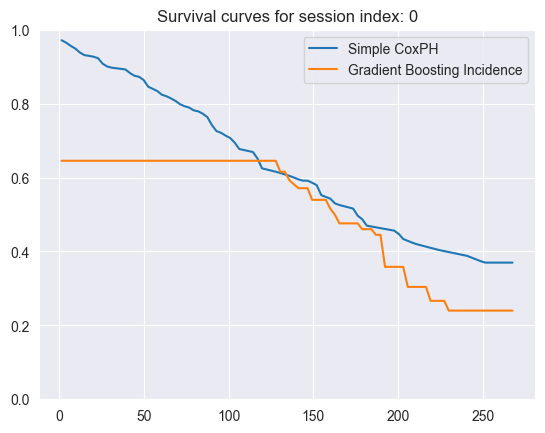

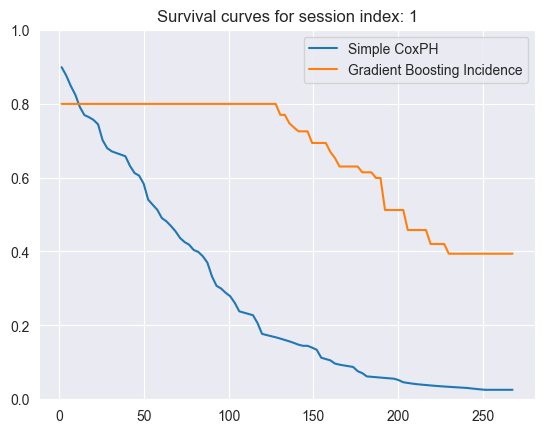

In [25]:
for idx in range(2):
    fig, ax = plt.subplots()
    ax.plot(time_grid, simple_cox_survival_probas[idx, :], label="Simple CoxPH")
    ax.plot(time_grid, gb_incidence_survival_probas[idx, :], label="Gradient Boosting Incidence")
    ax.set(title=f"Survival curves for session index: {idx}")
    plt.legend()
    plt.ylim([0, 1]);

[(0.0, 1.0)]

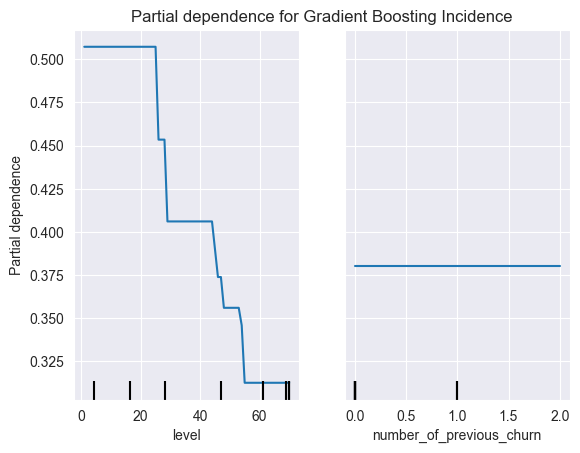

In [26]:
from sklearn.inspection import PartialDependenceDisplay

estimator = gb_incidence[-1]
estimator.set_params(time_horizon=150, show_progressbar=False)

transformers = gb_incidence[:-1]

disp = PartialDependenceDisplay.from_estimator(
    estimator,
    transformers.transform(X_test),
    response_method="predict_proba",
    features=["level", "number_of_previous_churn"],
    feature_names=transformers.get_feature_names_out(),
)
disp.bounding_ax_.set(title=f"Partial dependence for Gradient Boosting Incidence")
ax.set(ylim=[0, 1])    

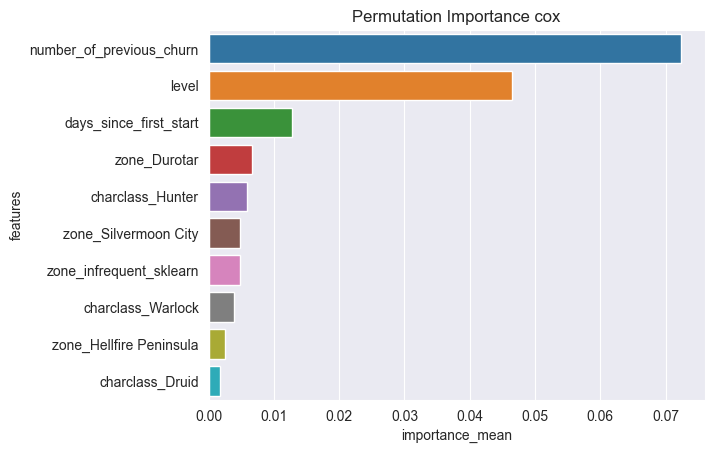

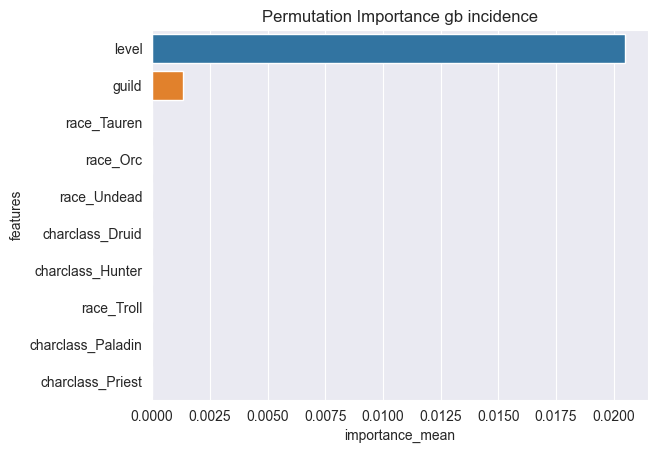

In [29]:
from sklearn.metrics import make_scorer
from sklearn.inspection import permutation_importance

from hazardous.metrics import integrated_brier_score


def ibs_scorer(estimator, X_test, y_test):
    surv_probas = estimator.predict_survival_function(X_test, times=time_grid)
    return -integrated_brier_score(y_train, y_test, surv_probas, time_grid)


gb_incidence[-1].set_params(show_progressbar=False)

estimators = {
    "cox": cox_ph[-1],
    "gb incidence": gb_incidence[-1],
}

for name, estimator in estimators.items():
    results = permutation_importance(
        estimator,
        transformers.transform(X_test.iloc[:1000]),
        y_test.iloc[:1000],
        scoring=ibs_scorer,
        n_repeats=5,
    )

    random_permutations = pd.DataFrame(
        dict(
            importance_mean=results.importances_mean,
            features=transformers.get_feature_names_out(),
        )
    ).sort_values("importance_mean", ascending=False).head(10)

    fig, ax = plt.subplots()
    sns.barplot(
        y=random_permutations["features"],
        x=random_permutations["importance_mean"],
        orient="h",
        ax=ax,
    )
    ax.set(title=f"Permutation Importance {name}")


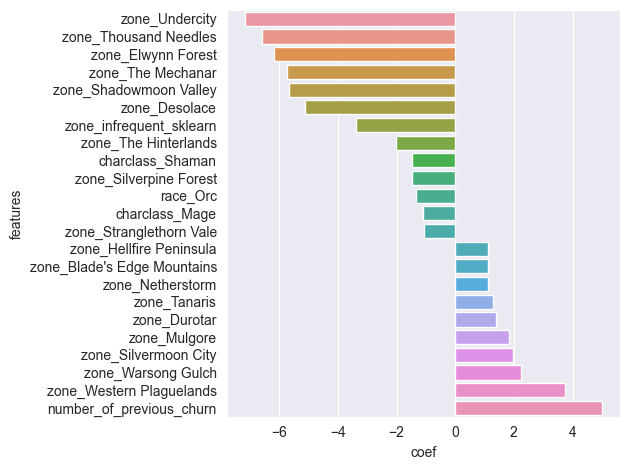

In [36]:
cox_coef = pd.DataFrame(
    dict(
        coef=cox_ph[-1].coef_,
        features=cox_ph[:-1].get_feature_names_out(),
    )
).sort_values("coef")

sns.barplot(
    cox_coef.loc[cox_coef["coef"].abs() > 1],
    x="coef",
    y="features",
)
plt.tight_layout()

In [37]:
cox_coef.loc[cox_coef["features"] == "level"]

,coef,features
44,-0.029917,level


In [38]:
X_train[["days_since_first_start", "level"]].corr()

,days_since_first_start,level
days_since_first_start,1.000000,0.021491
level,0.021491,1.000000


***Wrap-up exercise***

- Select 10 dates randomly from the beginning of January to the end of November (increment the first date with random number of days). For each sample date, define an observation window of 5 days: extract the censored data and concatenate those sessions into a training set;

- Estimate and plot the average survival function using a Kaplan-Meier estimator;

- Reiterate the KM estimation, but stratified on the `race` or the `charclass` features;

- Fit a predictive survival model of your choice with adequate feature engineering on this training set;

- Extract censored data from the last month of the original dataset and use it to measure the performance of your estimator with the metrics of your choice. Compare this to the Kaplan-Meier baseline.

- Inspect which features are the most predictive, one way or another.

In [ ]:
# Write your code here